In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score

import time

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
combine = [train_df, test_df]

# Q1. (Task 1) Pre-processing

In [3]:
# Columns with null values in train dataset
train_null_columns = train_df.columns[train_df.isnull().any()].tolist()

# Columns with null values in test dataset
test_null_columns = test_df.columns[test_df.isnull().any()].tolist()

print("Columns with null values in train dataset:", train_null_columns)
print("Columns with null values in test dataset:", test_null_columns)


Columns with null values in train dataset: ['Age', 'Cabin', 'Embarked']
Columns with null values in test dataset: ['Age', 'Fare', 'Cabin']


In [4]:
train_df['Age'].fillna(train_df['Age'].mean(), inplace=True)
test_df['Age'].fillna(test_df['Age'].mean(), inplace=True)

for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']

In [5]:
train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace=True)


In [6]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass




In [7]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)


for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

In [8]:
test_df['Fare'].fillna(test_df['Fare'].median(), inplace=True)
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)

for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)
combine = [train_df, test_df]

In [9]:
train_df = train_df.drop(['Ticket', 'Cabin', 'Parch', 'SibSp', 'FamilySize', 'Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin', 'Parch', 'SibSp', 'FamilySize', 'Name'], axis=1)

In [10]:
train_df.head()



,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1.0,0,0,1,0,3.0
1,1,1,1,2.0,3,1,3,0,2.0
2,1,3,1,1.0,1,0,2,1,3.0
3,1,1,1,2.0,3,0,3,0,2.0
4,0,3,0,2.0,1,0,1,1,6.0


# Q1. (Task 2) Learn, FineTune and Plot the Decision Tree

In [11]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 8), (891,), (418, 8))

In [12]:
from scipy.stats import randint

# Initialize Decision Tree Classifier
tree = DecisionTreeClassifier(random_state=42)

# Define parameter distributions
params = {
    'max_depth': [None, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None]
}


Decision Tree Training Time: 2.4835 seconds
Best Parameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 6, 'min_samples_split': 11}


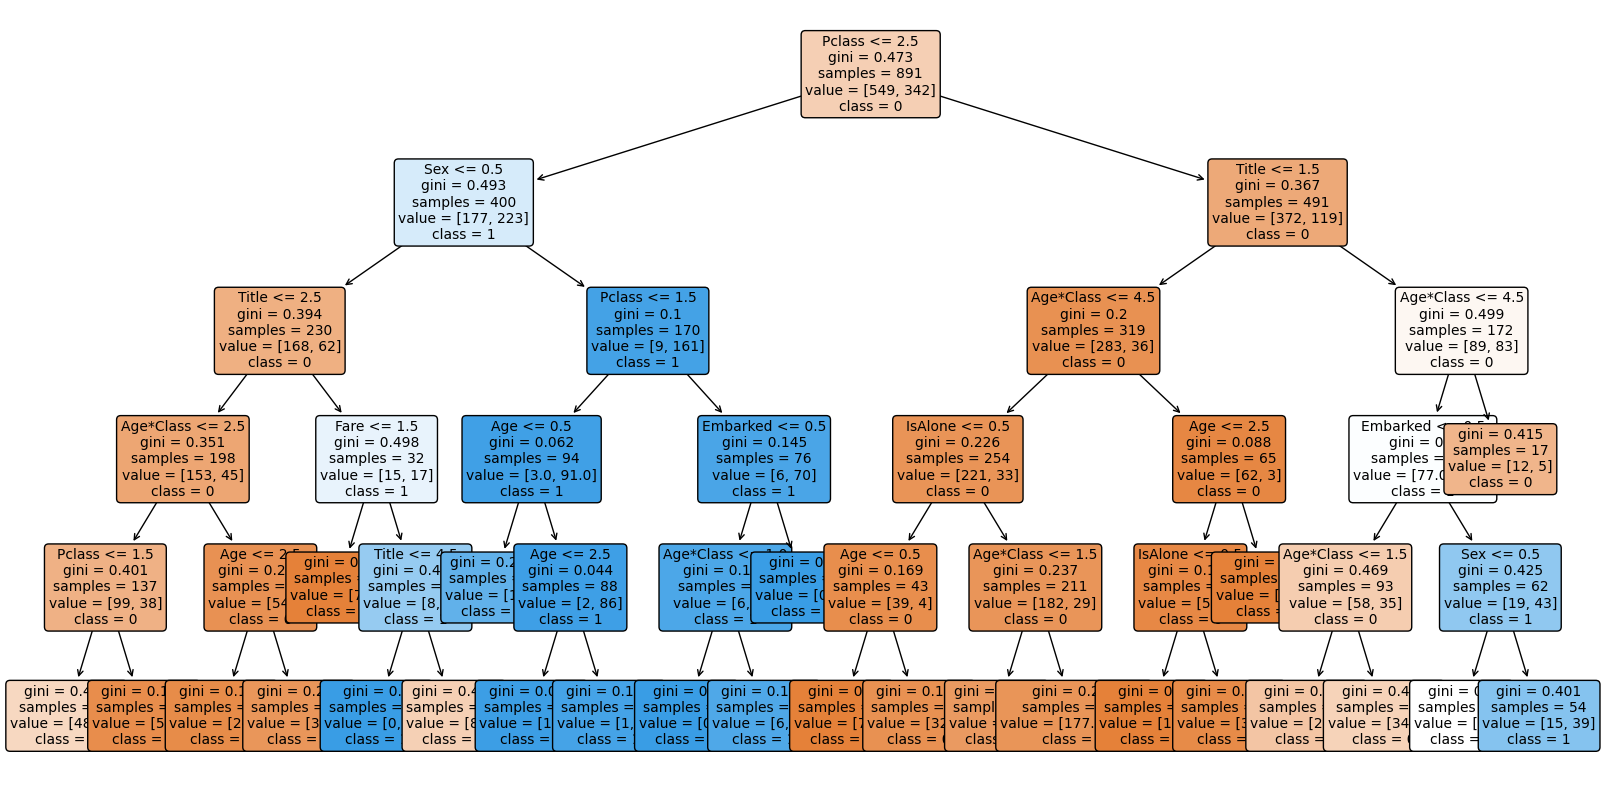

In [13]:

start_time = time.time()
random_search = RandomizedSearchCV(
    estimator=tree,
    param_distributions=params,
    n_iter=100, 
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, Y_train)
end_time = time.time()
print(f"Decision Tree Training Time: {end_time - start_time:.4f} seconds")

best_tree = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

plt.figure(figsize=(20, 10)) 
plot_tree(
    best_tree, 
    feature_names=X_train.columns, 
    class_names=np.unique(Y_train).astype(str), 
    filled=True, 
    rounded=True, 
    fontsize=10
)
plt.show()

# Q1. (Task 3) five-fold cross validation of your fine-tuned decision tree learning model to the Titanic training data to extract average classification accuracy;

In [14]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(best_tree, X_train, Y_train, cv=5, scoring='accuracy')

average_accuracy = cv_scores.mean()
print(f"5-Fold Cross-Validation Average Accuracy: {average_accuracy:.4f}")


5-Fold Cross-Validation Average Accuracy: 0.8215


# Q1. (Task 4) five-fold cross validation of your fine-tuned random forest learning model to the Titanic training data to extract average classification accuracy; 

In [15]:

start_time = time.time()
rf_params = {
    'n_estimators': [50, 75, 100, 150, 200, 250, 300],
    'max_depth': [None, 5, 10, 15, 20, 25, 30, 35, 40],
    'min_samples_split': [2, 5, 7, 10],
    'min_samples_leaf': [1, 2, 3, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Initialize RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Initialize RandomizedSearchCV with 5-fold CV
random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_params,
    n_iter=100,  # Number of random combinations
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

# Fit RandomizedSearchCV to find the best parameters for Random Forest
random_search_rf.fit(X_train, Y_train)

end_time = time.time()
print(f"RF Training Time: {end_time - start_time:.4f} seconds")

# Get the best model from RandomizedSearchCV
best_rf = random_search_rf.best_estimator_
print("Best Parameters for Random Forest:", random_search_rf.best_params_)

# Perform 5-fold cross-validation on the best Random Forest model and calculate the average accuracy
rf_cv_scores = cross_val_score(best_rf, X_train, Y_train, cv=5, scoring='accuracy')
average_rf_accuracy = rf_cv_scores.mean()

print(f"5-Fold Cross-Validation Average Accuracy for Random Forest: {average_rf_accuracy:.4f}")

RF Training Time: 8.0417 seconds
Best Parameters for Random Forest: {'n_estimators': 75, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 25}
5-Fold Cross-Validation Average Accuracy for Random Forest: 0.8272


# Q1. (Task 5) Which algorithm is better, Decision Tree or Random Forest? What are your observations and conclusions from the algorithm comparison and analysis?

While the difference here is not large, the analysis of the two algorithms gives the following observations and conclusions: 

According to the observed results Random Forest is better than Decision tree.<br>
5-Fold Cross-Validation Average Accuracy for Random Forest: 0.827 <br>
5-Fold Cross-Validation Average Accuracy for Decision Tree: 0.821 <br>


1. Accuracy & Robustness:<br>
The Random Forest model generally performs better in classification tasks as it uses an ensemble approach. Due to the ensemble it has more robustness against noise and outliers.

2. Model Stability and Robustness:<br>
Decision Tree: A single DT could easily overfit the training data. <br>
Random Forest: By using multiple trees and averaging and using de-correlation, Random Forest is more robust and avoids overfitting.

3. Computationally: <br>
Training a RF  uses more resources than DT due to the need to train multiple trees. In our case, RF was trained for 8.04s, while DT was trained for 2.48s
